In [200]:
# =============================================================================
# FINANCIAL CRISIS ANALYSIS: S&P 400 vs NIFTY 100
# =============================================================================
# This notebook analyzes idiosyncratic volatility and systematic risk evolution
# during financial crises using Rolling CAPM methodology
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [201]:
# =============================================================================
# CONFIGURATION AND PARAMETERS
# =============================================================================

# Rolling window size (252 trading days = 1 year)
WINDOW = 252

# Trading days per year (for annualization)
TRADING_DAYS = 252

# Crisis periods definition (start_date, end_date)
CRISES = [
    ("2008-01-01", "2009-06-30"),  # Global Financial Crisis
    ("2011-01-01", "2012-12-31"),  # European Debt Crisis
    ("2020-02-01", "2020-12-31"),  # COVID-19 Pandemic
    ("2022-01-01", "2023-12-31"),  # Inflation & Rate Hikes
]

# File paths (update these to match your file locations)
SP400_FILE = "SP400_Ready_Data.csv"
NIFTY_FILE = "Nifty100_Ready_Data.csv"

print("✓ Configuration parameters set")
print(f"  - Rolling window: {WINDOW} days")
print(f"  - Crisis periods defined: {len(CRISES)}")

✓ Configuration parameters set
  - Rolling window: 252 days
  - Crisis periods defined: 4


In [202]:
# =============================================================================
# BLOCK 1: DATA LOADING AND PREPARATION - S&P 400
# =============================================================================

print("\n" + "="*80)
print("LOADING S&P 400 DATA")
print("="*80)

# Load S&P 400 data
sp400_df = pd.read_csv(SP400_FILE)

# Clean column names (remove spaces and dots)
sp400_df.columns = sp400_df.columns.str.strip().str.replace(" ", "_").str.replace(".", "_")

# Convert Date to datetime and set as index
sp400_df['Date'] = pd.to_datetime(sp400_df['Date'])
sp400_df = sp400_df.set_index("Date").sort_index()

# Calculate risk-free rate (DTB3 = 3-month Treasury Bill annual yield)
# Convert from annual percentage to daily log return
# Formula: ln(1 + r/252) where r is annual rate
sp400_rf = np.log1p(sp400_df["DTB3"] / 100 / TRADING_DAYS)

# Calculate excess returns (market return - risk-free rate)
sp400_df["Rm_excess"] = sp400_df["Log_Returns"] - sp400_rf

# Handle MSCI World (Global Market) data
# Check if we have returns column or need to calculate from prices
msci_col_sp400 = "MSCI_World_Returns" if "MSCI_World_Returns" in sp400_df.columns else "MSCI_World_Last"

if "Returns" in msci_col_sp400:
    # Already have returns, just subtract risk-free rate
    sp400_df["Rg_excess"] = sp400_df[msci_col_sp400] - sp400_rf
else:
    # Calculate log returns from price levels, then subtract risk-free rate
    sp400_df["Rg_excess"] = np.log(sp400_df[msci_col_sp400]).diff() - sp400_rf

# Remove rows with missing values in key variables
sp400_df = sp400_df.dropna(subset=["Rm_excess", "Rg_excess"])

print(f"✓ S&P 400 data loaded: {len(sp400_df)} observations")
print(f"  Date range: {sp400_df.index.min().date()} to {sp400_df.index.max().date()}")
print(f"\nFirst few rows of excess returns:")
sp400_df[['Rm_excess', 'Rg_excess']].head()


LOADING S&P 400 DATA
✓ S&P 400 data loaded: 4792 observations
  Date range: 2006-01-03 to 2025-12-31

First few rows of excess returns:


,Rm_excess,Rg_excess
Date,,
2006-01-03,0.014593,0.017309
2006-01-04,0.006570,0.010566
2006-01-05,0.000129,0.000053
2006-01-06,0.011016,0.009631
2006-01-09,0.007580,0.000806


In [203]:
# =============================================================================
# BLOCK 2: DATA LOADING AND PREPARATION - NIFTY 100
# =============================================================================

print("\n" + "="*80)
print("LOADING NIFTY 100 DATA")
print("="*80)

# Load Nifty 100 data
nifty_df = pd.read_csv(NIFTY_FILE)

# Clean column names
nifty_df.columns = nifty_df.columns.str.strip().str.replace(" ", "_").str.replace(".", "_")

# Convert Date to datetime and set as index
nifty_df['Date'] = pd.to_datetime(nifty_df['Date'])
nifty_df = nifty_df.set_index("Date").sort_index()

# Calculate risk-free rate
nifty_rf = np.log1p(nifty_df["DTB3"] / 100 / TRADING_DAYS)

# Calculate excess returns
nifty_df["Rm_excess"] = nifty_df["Log_Returns"] - nifty_rf

# Handle MSCI World data
msci_col_nifty = "MSCI_World_Returns" if "MSCI_World_Returns" in nifty_df.columns else "MSCI_World_Last"

if "Returns" in msci_col_nifty:
    nifty_df["Rg_excess"] = nifty_df[msci_col_nifty] - nifty_rf
else:
    nifty_df["Rg_excess"] = np.log(nifty_df[msci_col_nifty]).diff() - nifty_rf

# Remove rows with missing values
nifty_df = nifty_df.dropna(subset=["Rm_excess", "Rg_excess"])

print(f"✓ Nifty 100 data loaded: {len(nifty_df)} observations")
print(f"  Date range: {nifty_df.index.min().date()} to {nifty_df.index.max().date()}")
print(f"\nFirst few rows of excess returns:")
nifty_df[['Rm_excess', 'Rg_excess']].head()


LOADING NIFTY 100 DATA
✓ Nifty 100 data loaded: 4792 observations
  Date range: 2006-01-03 to 2025-12-31

First few rows of excess returns:


,Rm_excess,Rg_excess
Date,,
2006-01-03,0.015490,0.017309
2006-01-04,0.013602,0.010566
2006-01-05,0.007708,0.000053
2006-01-06,0.009356,0.009631
2006-01-09,0.014381,0.000806


In [204]:
# =============================================================================
# BLOCK 3: ROLLING CAPM ESTIMATION - S&P 400
# =============================================================================

print("\n" + "="*80)
print("RUNNING ROLLING CAPM FOR S&P 400")
print("="*80)

# Estimate time-varying beta using Rolling OLS
# Formula: Rm_excess = alpha + beta * Rg_excess + epsilon
# Window: 252 trading days (1 year)
sp400_model = RollingOLS.from_formula(
    "Rm_excess ~ Rg_excess", 
    data=sp400_df, 
    window=WINDOW
)

sp400_results = sp400_model.fit()

# Extract time-varying parameters
sp400_df["beta"] = sp400_results.params["Rg_excess"]      # Systematic risk sensitivity
sp400_df["alpha"] = sp400_results.params["Intercept"]     # Jensen's alpha

# Calcolo rigoroso dell'IVOL (RMSE in-sample annualizzato per ogni finestra)
# RMSE = sqrt(SSR / (N - k)), dove N=WINDOW(252) e k=2 (Alpha e Beta)
sp400_df["IVOL"] = np.sqrt(sp400_results.ssr / (WINDOW - 2)) * np.sqrt(TRADING_DAYS)

# Calculate Total Volatility for comparison
sp400_df["Total_Vol"] = sp400_df["Rm_excess"].rolling(WINDOW).std() * np.sqrt(TRADING_DAYS)

# Calculate residuals (maintained for extra diagnostics if needed)
# epsilon_t = Rm_t - (alpha_t + beta_t * Rg_t)
sp400_df["epsilon"] = sp400_df["Rm_excess"] - (
    sp400_df["alpha"] + sp400_df["beta"] * sp400_df["Rg_excess"]
)

print(f"✓ Rolling CAPM completed for S&P 400")
print(f"\nBeta statistics:")
print(sp400_df["beta"].describe())
print(f"\nIVOL statistics:")
print(sp400_df["IVOL"].describe())

# Estrai R-squared rolling
sp400_df["R2"] = sp400_results.rsquared

print("\nRolling CAPM Statistics - S&P 400:")
print(f"  Average Beta:       {sp400_df['beta'].mean():.4f}")
print(f"  Average Alpha:      {sp400_df['alpha'].mean():.6f}")
print(f"  Average R²:         {sp400_df['R2'].mean():.4f}")
print(f"  Average IVOL:       {sp400_df['IVOL'].mean():.4f}")
print(f"  Average Total Vol:  {sp400_df['Total_Vol'].mean():.4f}")


RUNNING ROLLING CAPM FOR S&P 400
✓ Rolling CAPM completed for S&P 400

Beta statistics:
count    4541.000000
mean        1.150032
std         0.080606
min         0.987035
25%         1.084363
50%         1.148684
75%         1.207423
max         1.377632
Name: beta, dtype: float64

IVOL statistics:
count    4541.000000
mean        0.098558
std         0.038759
min         0.057300
25%         0.072503
50%         0.092379
75%         0.107474
max         0.241441
Name: IVOL, dtype: float64

Rolling CAPM Statistics - S&P 400:
  Average Beta:       1.1500
  Average Alpha:      0.000044
  Average R²:         0.7500
  Average IVOL:       0.0986
  Average Total Vol:  0.2055


In [205]:
# =============================================================================
# BLOCK 4: ROLLING CAPM ESTIMATION - NIFTY 100
# =============================================================================

print("\n" + "="*80)
print("RUNNING ROLLING CAPM FOR NIFTY 100")
print("="*80)

# Estimate time-varying beta using Rolling OLS
nifty_model = RollingOLS.from_formula(
    "Rm_excess ~ Rg_excess", 
    data=nifty_df, 
    window=WINDOW
)

nifty_results = nifty_model.fit()

# Extract time-varying parameters
nifty_df["beta"] = nifty_results.params["Rg_excess"]
nifty_df["alpha"] = nifty_results.params["Intercept"]

# Calcolo rigoroso dell'IVOL (RMSE in-sample)
nifty_df["IVOL"] = np.sqrt(nifty_results.ssr / (WINDOW - 2)) * np.sqrt(TRADING_DAYS)

# Calculate Total Volatility for comparison
nifty_df["Total_Vol"] = nifty_df["Rm_excess"].rolling(WINDOW).std() * np.sqrt(TRADING_DAYS)

# Calculate residuals 
nifty_df["epsilon"] = nifty_df["Rm_excess"] - (
    nifty_df["alpha"] + nifty_df["beta"] * nifty_df["Rg_excess"]
)

print(f"✓ Rolling CAPM completed for Nifty 100")
print(f"\nBeta statistics:")
print(nifty_df["beta"].describe())
print(f"\nIVOL statistics:")
print(nifty_df["IVOL"].describe())

# Estrai R-squared rolling
nifty_df["R2"] = nifty_results.rsquared

print("\nRolling CAPM Statistics - Nifty 100:")
print(f"  Average Beta:       {nifty_df['beta'].mean():.4f}")
print(f"  Average Alpha:      {nifty_df['alpha'].mean():.6f}")
print(f"  Average R²:         {nifty_df['R2'].mean():.4f}")
print(f"  Average IVOL:       {nifty_df['IVOL'].mean():.4f}")
print(f"  Average Total Vol:  {nifty_df['Total_Vol'].mean():.4f}")


RUNNING ROLLING CAPM FOR NIFTY 100
✓ Rolling CAPM completed for Nifty 100

Beta statistics:
count    4541.000000
mean        0.546445
std         0.194905
min         0.089289
25%         0.428573
50%         0.542507
75%         0.639574
max         1.318059
Name: beta, dtype: float64

IVOL statistics:
count    4541.000000
mean        0.220184
std         0.057948
min         0.122902
25%         0.186380
50%         0.202311
75%         0.233706
max         0.397030
Name: IVOL, dtype: float64

Rolling CAPM Statistics - Nifty 100:
  Average Beta:       0.5464
  Average Alpha:      0.000240
  Average R²:         0.1243
  Average IVOL:       0.2202
  Average Total Vol:  0.2367


In [206]:
# =============================================================================
# HELPER FUNCTION: STATISTICAL DIAGNOSTICS
# =============================================================================
def run_statistical_diagnostics(df, index_name, vars_to_test):
    """
    Runs ADF (stationarity) and Jarque-Bera (normality) tests
    for each variable in vars_to_test on the given DataFrame.
    """
    print("\n" + "="*80)
    print(f"STATISTICAL DIAGNOSTICS: {index_name}")
    print("="*80)
    print("-" * 85)
    print(f"{'VARIABLE':<15} | {'TEST NAME':<15} | {'STATISTIC':<10} | {'P-VALUE':<10} | {'RESULT'}")
    print("-" * 85)

    for var in vars_to_test:
        if var not in df.columns:
            continue

        # Drop NaNs (rolling windows create NaNs at the beginning)
        series = df[var].dropna()

        if len(series) < 20:
            continue

        # Test 1: Augmented Dickey-Fuller (Stationarity Test)
        # H0: Series has unit root (non-stationary)
        # H1: Series is stationary
        adf_stat, adf_p = adfuller(series)[:2]
        is_stationary = "STATIONARY" if adf_p < 0.05 else "NON-STATIONARY"
        print(f"{var:<15} | {'ADF (Unit Root)':<15} | {adf_stat:<10.4f} | {adf_p:<10.4f} | {is_stationary}")

        # Test 2: Jarque-Bera (Normality Test)
        # H0: Data is normally distributed
        # H1: Data is not normally distributed (fat tails, skewness)
        jb_stat, jb_p, _, _ = jarque_bera(series)
        is_normal = "NORMAL" if jb_p > 0.05 else "NOT NORMAL"
        print(f"{var:<15} | {'Jarque-Bera':<15} | {jb_stat:<10.4f} | {jb_p:<10.4f} | {is_normal}")

    print("-" * 85)


# =============================================================================
# BLOCKS 5 & 6: STATISTICAL DIAGNOSTICS - S&P 400 & NIFTY 100
# =============================================================================
vars_to_test = ['Rm_excess', 'IVOL', 'Total_Vol']

run_statistical_diagnostics(sp400_df,  "S&P 400",   vars_to_test)
run_statistical_diagnostics(nifty_df,  "NIFTY 100", vars_to_test)


STATISTICAL DIAGNOSTICS: S&P 400
-------------------------------------------------------------------------------------
VARIABLE        | TEST NAME       | STATISTIC  | P-VALUE    | RESULT
-------------------------------------------------------------------------------------
Rm_excess       | ADF (Unit Root) | -14.2176   | 0.0000     | STATIONARY
Rm_excess       | Jarque-Bera     | 23633.3916 | 0.0000     | NOT NORMAL
IVOL            | ADF (Unit Root) | -2.5738    | 0.0985     | NON-STATIONARY
IVOL            | Jarque-Bera     | 7629.0680  | 0.0000     | NOT NORMAL
Total_Vol       | ADF (Unit Root) | -2.7625    | 0.0638     | NON-STATIONARY
Total_Vol       | Jarque-Bera     | 2074.9926  | 0.0000     | NOT NORMAL
-------------------------------------------------------------------------------------

STATISTICAL DIAGNOSTICS: NIFTY 100
-------------------------------------------------------------------------------------
VARIABLE        | TEST NAME       | STATISTIC  | P-VALUE    | RESULT
--

In [207]:
# =============================================================================
# BLOCK 7: CRISIS DUMMY VARIABLE CREATION
# =============================================================================

print("\n" + "="*80)
print("CREATING CRISIS DUMMY VARIABLES")
print("="*80)

# Initialize crisis dummy as 0 (normal periods)
sp400_df["Is_Crisis"] = 0
nifty_df["Is_Crisis"] = 0

# Mark crisis periods as 1
for start, end in CRISES:
    sp400_df.loc[start:end, "Is_Crisis"] = 1
    nifty_df.loc[start:end, "Is_Crisis"] = 1
    print(f"  Marked crisis period: {start} to {end}")

# Count crisis vs normal observations
sp400_crisis_count = sp400_df["Is_Crisis"].sum()
nifty_crisis_count = nifty_df["Is_Crisis"].sum()

print(f"\n✓ Crisis periods marked")
print(f"  S&P 400: {sp400_crisis_count} crisis days ({sp400_crisis_count/len(sp400_df)*100:.1f}%)")
print(f"  Nifty 100: {nifty_crisis_count} crisis days ({nifty_crisis_count/len(nifty_df)*100:.1f}%)")


CREATING CRISIS DUMMY VARIABLES
  Marked crisis period: 2008-01-01 to 2009-06-30
  Marked crisis period: 2011-01-01 to 2012-12-31
  Marked crisis period: 2020-02-01 to 2020-12-31
  Marked crisis period: 2022-01-01 to 2023-12-31

✓ Crisis periods marked
  S&P 400: 1534 crisis days (32.0%)
  Nifty 100: 1534 crisis days (32.0%)


In [208]:
# =============================================================================
# BLOCK 7.5: OPTIMAL LAG SELECTION (INSERT AFTER BLOCK 7 - CRISIS DUMMY)
# =============================================================================

print("\n" + "="*80)
print("OPTIMAL LAG SELECTION FOR AR MODEL")
print("="*80)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import acorr_ljungbox

# =============================================================================
# FIX 1: VERIFICA E RINOMINA LA COLONNA CRISIS
# =============================================================================

# Stampa le colonne per debug (puoi commentare dopo aver verificato)
print("\nColonne sp400_df:", sp400_df.columns.tolist())
print("Colonne nifty_df: ", nifty_df.columns.tolist())

# Mappa automatica: cerca la colonna crisis indipendentemente dal nome esatto
def normalize_crisis_column(df, possible_names=None):
    """
    Rinomina in 'Is_Crisis' la colonna crisis, qualunque sia il suo nome attuale.
    Lancia un errore chiaro se non la trova.
    """
    if possible_names is None:
        possible_names = [
            'Is_Crisis', 'is_crisis', 'IS_CRISIS',
            'Crisis', 'crisis', 'CRISIS',
            'crisis_dummy', 'Crisis_Dummy', 'CrisisDummy',
            'is_financial_crisis', 'financial_crisis'
        ]
    
    df = df.copy()
    
    # Se esiste già con il nome corretto, non fare nulla
    if 'Is_Crisis' in df.columns:
        return df
    
    # Cerca tra i nomi possibili
    for name in possible_names:
        if name in df.columns:
            print(f"  ✓ Colonna crisis trovata come '{name}' -> rinominata in 'Is_Crisis'")
            df = df.rename(columns={name: 'Is_Crisis'})
            return df
    
    # Se non trovata, lancia un errore chiaro
    raise ValueError(
        f"Nessuna colonna crisis trovata nel DataFrame.\n"
        f"Colonne disponibili: {df.columns.tolist()}\n"
        f"Rinomina manualmente la colonna crisis in 'Is_Crisis'."
    )

print("\nNormalizzazione colonne crisis...")
sp400_df = normalize_crisis_column(sp400_df)
nifty_df  = normalize_crisis_column(nifty_df)

# =============================================================================
# FUNZIONE PRINCIPALE: LAG SELECTION
# =============================================================================

def select_optimal_lags(data, variable, max_lags=10, crisis_dummy=True):
    """
    Selects optimal lag order using information criteria.
    
    Parameters:
    -----------
    data : DataFrame
        Input data containing the variable and (optionally) 'Is_Crisis'
    variable : str
        Name of the variable to model (e.g., 'IVOL', 'Total_Vol')
    max_lags : int
        Maximum number of lags to test (default: 10)
    crisis_dummy : bool
        Whether to include crisis dummy in the model
        
    Returns:
    --------
    dict : Dictionary with optimal lags for each criterion and results table
    """
    
    results = []
    
    print(f"\nTesting lags for: {variable}")
    print("-" * 80)
    
    for p in range(1, max_lags + 1):
        # Crea variabili laggiate
        temp_df = data.copy()
        for i in range(1, p + 1):
            temp_df[f'{variable}_Lag{i}'] = temp_df[variable].shift(i)
        
        # Costruisce la formula
        lags_str = ' + '.join([f'{variable}_Lag{i}' for i in range(1, p + 1)])
        if crisis_dummy:
            formula = f"{variable} ~ {lags_str} + Is_Crisis"
        else:
            formula = f"{variable} ~ {lags_str}"
        
        # Stima il modello
        try:
            model = smf.ols(formula, data=temp_df.dropna()).fit()
            
            # Criteri di informazione
            aic  = model.aic
            bic  = model.bic
            
            # HQIC (Hannan-Quinn) calcolato manualmente
            nobs = model.nobs
            k    = len(model.params)
            hqic = -2 * model.llf + 2 * k * np.log(np.log(nobs))
            
            # Ljung-Box test sui residui
            lb_lags   = min(p + 5, len(model.resid) // 5)
            lb_test   = acorr_ljungbox(model.resid, lags=lb_lags, return_df=True)
            lb_pvalue = lb_test['lb_pvalue'].min()  # p-value più conservativo
            
            results.append({
                'Lags'    : p,
                'AIC'     : aic,
                'BIC'     : bic,
                'HQIC'    : hqic,
                'R²'      : model.rsquared,
                'Adj_R²'  : model.rsquared_adj,
                'LB_pvalue': lb_pvalue,
                'LB_Pass' : 'Yes' if lb_pvalue > 0.05 else 'No'
            })
            
        except Exception as e:
            print(f"  Warning: Could not fit model with {p} lags: {e}")
            continue
    
    # FIX 2: Guard contro risultati vuoti
    if not results:
        raise ValueError(
            f"Nessun modello stimato con successo per '{variable}'.\n"
            f"Verifica che la variabile esista nel DataFrame e che "
            f"'Is_Crisis' sia presente se crisis_dummy=True."
        )
    
    # Converti in DataFrame
    results_df = pd.DataFrame(results)
    
    # Lag ottimale per ciascun criterio (minimo)
    optimal_aic  = results_df.loc[results_df['AIC'].idxmin(),  'Lags']
    optimal_bic  = results_df.loc[results_df['BIC'].idxmin(),  'Lags']
    optimal_hqic = results_df.loc[results_df['HQIC'].idxmin(), 'Lags']
    
    # Primo lag che supera il Ljung-Box test
    lb_pass    = results_df[results_df['LB_Pass'] == 'Yes']
    optimal_lb = int(lb_pass['Lags'].min()) if len(lb_pass) > 0 else max_lags
    
    # Stampa tabella risultati
    print(f"\n{'Lags':<6} {'AIC':<14} {'BIC':<14} {'HQIC':<14} {'R²':<8} {'Adj R²':<8} {'LB p-val':<10} {'Pass':<6}")
    print("-" * 84)
    
    for _, row in results_df.iterrows():
        aic_str  = f"{row['AIC']:.2f}"  + ('*' if row['Lags'] == optimal_aic  else '')
        bic_str  = f"{row['BIC']:.2f}"  + ('*' if row['Lags'] == optimal_bic  else '')
        hqic_str = f"{row['HQIC']:.2f}" + ('*' if row['Lags'] == optimal_hqic else '')
        
        print(f"{int(row['Lags']):<6} {aic_str:<14} {bic_str:<14} {hqic_str:<14} "
              f"{row['R²']:.4f}  {row['Adj_R²']:.4f}  {row['LB_pvalue']:.4f}    {row['LB_Pass']:<6}")
    
    print("\n" + "-" * 84)
    print("OPTIMAL LAG SELECTION:")
    print(f"  AIC  suggests : {int(optimal_aic)} lags")
    print(f"  BIC  suggests : {int(optimal_bic)} lags (more parsimonious)")
    print(f"  HQIC suggests : {int(optimal_hqic)} lags")
    print(f"  Ljung-Box passes at: {int(optimal_lb)} lags (no autocorrelation)")
    
    # Raccomandazione: BIC (conservativo) con validazione Ljung-Box
    recommended = max(int(optimal_bic), int(optimal_lb))
    print(f"\n  ✓ RECOMMENDED: {recommended} lags")
    print(f"    Rationale: BIC criterion with Ljung-Box validation")
    
    return {
        'optimal_aic' : int(optimal_aic),
        'optimal_bic' : int(optimal_bic),
        'optimal_hqic': int(optimal_hqic),
        'optimal_lb'  : int(optimal_lb),
        'recommended' : recommended,
        'results_df'  : results_df
    }


# =============================================================================
# RUN LAG SELECTION PER ENTRAMBI I MERCATI E VARIABILI
# =============================================================================

print("\n" + "="*80)
print("S&P 400 - LAG SELECTION")
print("="*80)

optimal_lags = {}

sp400_ivol_lags = select_optimal_lags(sp400_df, 'IVOL',      max_lags=10, crisis_dummy=True)
optimal_lags['sp400_ivol'] = sp400_ivol_lags['recommended']

sp400_tvol_lags = select_optimal_lags(sp400_df, 'Total_Vol', max_lags=10, crisis_dummy=True)
optimal_lags['sp400_tvol'] = sp400_tvol_lags['recommended']

print("\n" + "="*80)
print("NIFTY 100 - LAG SELECTION")
print("="*80)

nifty_ivol_lags = select_optimal_lags(nifty_df, 'IVOL',      max_lags=10, crisis_dummy=True)
optimal_lags['nifty_ivol'] = nifty_ivol_lags['recommended']

nifty_tvol_lags = select_optimal_lags(nifty_df, 'Total_Vol', max_lags=10, crisis_dummy=True)
optimal_lags['nifty_tvol'] = nifty_tvol_lags['recommended']


# =============================================================================
# SUMMARY E RACCOMANDAZIONE FINALE
# =============================================================================

print("\n" + "="*80)
print("FINAL LAG SELECTION SUMMARY")
print("="*80)

summary_df = pd.DataFrame({
    'Market'       : ['S&P 400', 'S&P 400',   'Nifty 100', 'Nifty 100'],
    'Variable'     : ['IVOL',    'Total Vol',  'IVOL',      'Total Vol'],
    'Optimal Lags' : [
        optimal_lags['sp400_ivol'],
        optimal_lags['sp400_tvol'],
        optimal_lags['nifty_ivol'],
        optimal_lags['nifty_tvol']
    ]
})
print(summary_df.to_string(index=False))

# Lag globale: usa il massimo per coerenza tra modelli
LAGS_OPTIMAL = max(optimal_lags.values())

print("\n" + "="*80)
print(f"GLOBAL LAG ORDER: {LAGS_OPTIMAL}")
print("="*80)
print(f"Using {LAGS_OPTIMAL} lags for all subsequent regressions to ensure:")
print("  1. Consistency across models")
print("  2. Adequate control for autocorrelation")
print("  3. No omitted variable bias")
print("  4. Clean residuals (white noise)")

print(f"\n✓ LAG SELECTION COMPLETED")
print(f"  Original LAGS = 5 (arbitrary)")
print(f"  Optimal LAGS  = {LAGS_OPTIMAL} (data-driven)")

# Aggiorna LAGS per i blocchi successivi
LAGS = LAGS_OPTIMAL

print(f"\n⚠️  IMPORTANT: Use LAGS = {LAGS} in Blocks 8 and 9 (AR regressions)")


OPTIMAL LAG SELECTION FOR AR MODEL

Colonne sp400_df: ['Open', 'High', 'Low', 'Last', 'Volume', 'Log_Returns', 'DTB3', 'MSCI_World_Last', 'MSCI_World_Returns', 'Rm_excess', 'Rg_excess', 'beta', 'alpha', 'IVOL', 'Total_Vol', 'epsilon', 'R2', 'Is_Crisis']
Colonne nifty_df:  ['Open', 'High', 'Low', 'Last', 'Volume', 'Log_Returns', 'DTB3', 'MSCI_World_Last', 'MSCI_World_Returns', 'Rm_excess', 'Rg_excess', 'beta', 'alpha', 'IVOL', 'Total_Vol', 'epsilon', 'R2', 'Is_Crisis']

Normalizzazione colonne crisis...

S&P 400 - LAG SELECTION

Testing lags for: IVOL
--------------------------------------------------------------------------------

Lags   AIC            BIC            HQIC           R²       Adj R²   LB p-val   Pass  
------------------------------------------------------------------------------------
1      -53417.22      -53397.96      -53410.44      0.9997  0.9997  0.0000    No    
2      -53655.99      -53630.31      -53646.94      0.9997  0.9997  0.0000    No    
3      -53905.37 

In [209]:
# =============================================================================
# BLOCK 8-9: AR(p) REGRESSION WITH CRISIS DUMMY (STATIONARY CORRECTION)
# =============================================================================

def run_ar_crisis_regression(df, index_name, lags=LAGS):
    """
    Runs AR(p) + Crisis Dummy OLS regression (HAC std errors) for DIFFERENCED 
    IVOL and Total_Vol on the given dataframe to prevent spurious regression.

    Parameters
    ----------
    df          : pd.DataFrame  – must contain 'IVOL', 'Total_Vol', 'Is_Crisis'
    index_name  : str           – label printed in the header (e.g. "S&P 400")
    lags        : int           – number of AR lags (default: global LAGS)

    Returns
    -------
    reg_results : dict  – {var: {"coeff", "p", "t"}}
    """
    print("\n" + "="*80)
    print(f"AR({lags}) + CRISIS DUMMY REGRESSION (First Differences): {index_name}")
    print("="*80)

    reg_results = {}

    for var in ["IVOL", "Total_Vol"]:
        print(f"\n--- Analyzing Δ{var} (First Differences) ---")

        # 1. Creazione della serie stazionaria in differenze prime (ΔY_t = Y_t - Y_{t-1})
        d_var = f"d_{var}"
        df[d_var] = df[var].diff()

        # 2. Creazione dei lag basati sulla nuova serie differenziata (AR terms)
        for i in range(1, lags + 1):
            df[f"{d_var}_Lag{i}"] = df[d_var].shift(i)

        # Formula: ΔY_t = β0 + β1*ΔY_{t-1} + ... + βp*ΔY_{t-p} + γ*Crisis_Dummy + ε_t
        lags_str = ' + '.join([f'{d_var}_Lag{i}' for i in range(1, lags + 1)])
        formula  = f"{d_var} ~ {lags_str} + Is_Crisis"

        # Fit OLS with Newey-West (HAC) standard errors
        # L'utilizzo di dropna() eliminerà automaticamente i NaN generati da diff() e shift()
        reg = smf.ols(formula, data=df.dropna()).fit(
            cov_type='HAC',
            cov_kwds={'maxlags': lags}
        )

        reg_results[var] = {
            "coeff": reg.params['Is_Crisis'],
            "p":     reg.pvalues['Is_Crisis'],
            "t":     reg.tvalues['Is_Crisis']
        }

        print(f"  Crisis Coefficient (γ) su Δ{var}: {reg_results[var]['coeff']:.6f}")
        print(f"  P-value:                {reg_results[var]['p']:.4f}")
        print(f"  T-statistic:            {reg_results[var]['t']:.4f}")
        print(f"  Significant at 5%:      {'Yes' if reg_results[var]['p'] < 0.05 else 'No'}")
        print(f"  R-squared:              {reg.rsquared:.4f}")

    return reg_results


# --- Chiamate ---
sp400_reg_results = run_ar_crisis_regression(sp400_df, "S&P 400")
nifty_reg_results = run_ar_crisis_regression(nifty_df, "NIFTY 100")


AR(10) + CRISIS DUMMY REGRESSION (First Differences): S&P 400

--- Analyzing ΔIVOL (First Differences) ---
  Crisis Coefficient (γ) su ΔIVOL: 0.000070
  P-value:                0.0001
  T-statistic:            3.8358
  Significant at 5%:      Yes
  R-squared:              0.1624

--- Analyzing ΔTotal_Vol (First Differences) ---
  Crisis Coefficient (γ) su ΔTotal_Vol: 0.000122
  P-value:                0.0031
  T-statistic:            2.9537
  Significant at 5%:      Yes
  R-squared:              0.2969

AR(10) + CRISIS DUMMY REGRESSION (First Differences): NIFTY 100

--- Analyzing ΔIVOL (First Differences) ---
  Crisis Coefficient (γ) su ΔIVOL: 0.000128
  P-value:                0.0120
  T-statistic:            2.5121
  Significant at 5%:      Yes
  R-squared:              0.0664

--- Analyzing ΔTotal_Vol (First Differences) ---
  Crisis Coefficient (γ) su ΔTotal_Vol: 0.000140
  P-value:                0.0075
  T-statistic:            2.6724
  Significant at 5%:      Yes
  R-squared: 

In [210]:
# =============================================================================
# BLOCK 10: MERGE DATA FOR COMPARATIVE ANALYSIS
# =============================================================================

print("\n" + "="*80)
print("PREPARING COMPARATIVE ANALYSIS")
print("="*80)

# Merge the two datasets on Date index for direct comparison
# Keep only beta, IVOL, and crisis dummy from both markets
comp_df = pd.merge(
    sp400_df[['beta', 'IVOL', 'Is_Crisis']], 
    nifty_df[['beta', 'IVOL']], 
    left_index=True, 
    right_index=True, 
    suffixes=('_S&P400', '_Nifty100')
).dropna()

print(f"✓ Merged dataset created")
print(f"  Common observations: {len(comp_df)}")
print(f"  Date range: {comp_df.index.min().date()} to {comp_df.index.max().date()}")
print(f"\nFirst few rows:")
print(comp_df.head())


PREPARING COMPARATIVE ANALYSIS
✓ Merged dataset created
  Common observations: 4541
  Date range: 2007-01-19 to 2025-12-31

First few rows:
            beta_S&P400  IVOL_S&P400  Is_Crisis  beta_Nifty100  IVOL_Nifty100
Date                                                                         
2007-01-19     1.077749     0.085151          0       1.146974       0.268550
2007-01-22     1.085202     0.085082          0       1.154357       0.268534
2007-01-23     1.091550     0.084997          0       1.145051       0.269288
2007-01-24     1.093570     0.085060          0       1.144451       0.269191
2007-01-25     1.096038     0.085153          0       1.130239       0.270014


In [211]:
# =============================================================================
# BLOCK 11: COMPARATIVE STATISTICS
# =============================================================================

print("\n" + "="*80)
print("COMPARATIVE ANALYSIS: S&P 400 vs NIFTY 100")
print("="*80)

# 1. MARKET SYNCHRONIZATION
print("\n1. MARKET SYNCHRONIZATION:")

# Correlation of systematic risk (beta)
corr_beta = comp_df['beta_S&P400'].corr(comp_df['beta_Nifty100'])
print(f"   > Beta Correlation:       {corr_beta:.4f}")

# Correlation of idiosyncratic volatility
corr_ivol = comp_df['IVOL_S&P400'].corr(comp_df['IVOL_Nifty100'])
print(f"   > IVOL Correlation:       {corr_ivol:.4f}")

# Interpret synchronization level
sync_level = 'High' if corr_ivol > 0.7 else 'Moderate' if corr_ivol > 0.4 else 'Low'
print(f"   Insight: {sync_level} synchronization of idiosyncratic volatility.")

# 2. CRISIS SENSITIVITY
print(f"\n2. CRISIS SENSITIVITY (IVOL Impact Coefficients):")

beta_sens_sp400 = sp400_reg_results['IVOL']['coeff']
beta_sens_nifty = nifty_reg_results['IVOL']['coeff']

print(f"   > S&P 400: {beta_sens_sp400:.6f} (p={sp400_reg_results['IVOL']['p']:.4f})")
print(f"   > Nifty 100: {beta_sens_nifty:.6f} (p={nifty_reg_results['IVOL']['p']:.4f})")

# Calculate relative sensitivity
ratio = beta_sens_sp400 / beta_sens_nifty if beta_sens_nifty != 0 else 0
print(f"   Insight: S&P 400 is {ratio:.2f}x more sensitive to crises than Nifty 100.")

# 3. CONTAGION ANALYSIS
print(f"\n3. CONTAGION EFFECT (Correlation Analysis):")

# Split data into crisis and normal periods
crisis_df = comp_df[comp_df['Is_Crisis'] == 1]
normal_df = comp_df[comp_df['Is_Crisis'] == 0]

# Calculate correlations separately for each period
corr_normal = normal_df['IVOL_S&P400'].corr(normal_df['IVOL_Nifty100'])
corr_crisis = crisis_df['IVOL_S&P400'].corr(crisis_df['IVOL_Nifty100'])

print(f"   > IVOL Correlation (Normal Periods): {corr_normal:.4f}")
print(f"   > IVOL Correlation (During CRISIS):  {corr_crisis:.4f}")
print(f"   > Difference: {corr_crisis - corr_normal:+.4f}")

# Interpret contagion
if corr_crisis > corr_normal:
    print(f"   Insight: CONTAGION DETECTED. Market dependence increases significantly during stress.")
else:
    print(f"   Insight: DECOUPLING DETECTED. Markets tend to move independently during crises.")


COMPARATIVE ANALYSIS: S&P 400 vs NIFTY 100

1. MARKET SYNCHRONIZATION:
   > Beta Correlation:       -0.3393
   > IVOL Correlation:       0.7737
   Insight: High synchronization of idiosyncratic volatility.

2. CRISIS SENSITIVITY (IVOL Impact Coefficients):
   > S&P 400: 0.000070 (p=0.0001)
   > Nifty 100: 0.000128 (p=0.0120)
   Insight: S&P 400 is 0.55x more sensitive to crises than Nifty 100.

3. CONTAGION EFFECT (Correlation Analysis):
   > IVOL Correlation (Normal Periods): 0.7519
   > IVOL Correlation (During CRISIS):  0.7635
   > Difference: +0.0116
   Insight: CONTAGION DETECTED. Market dependence increases significantly during stress.



GENERATING CORRELATION MATRICES


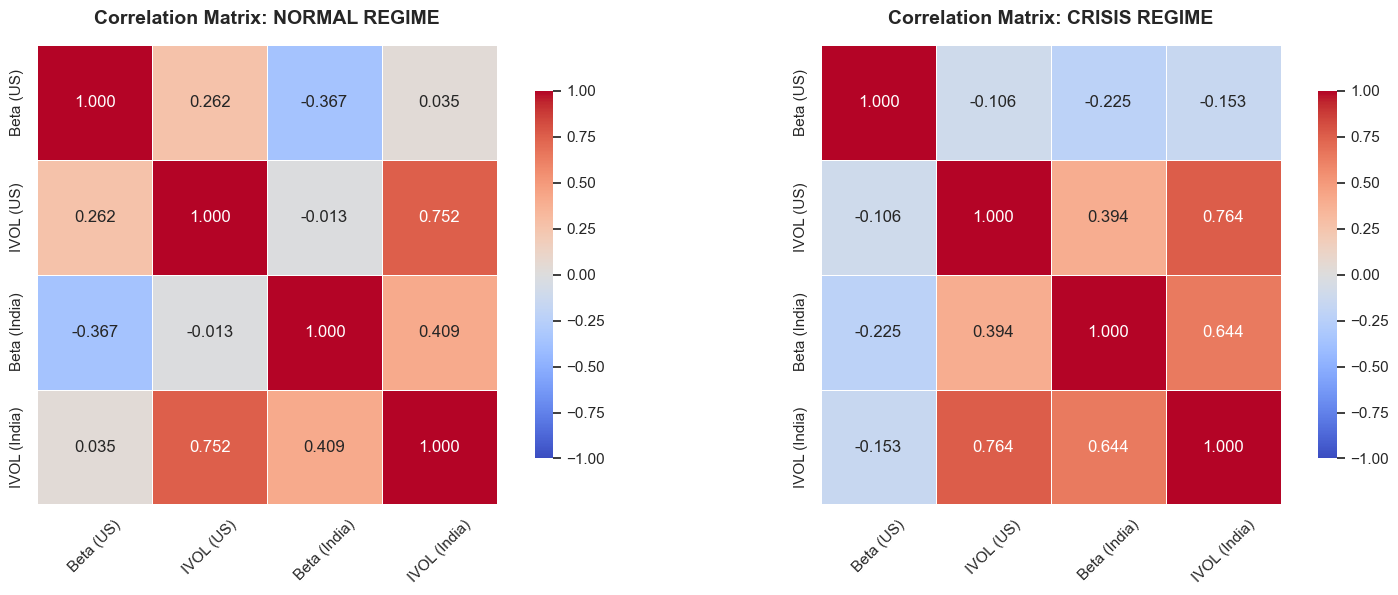

✓ Matrici di correlazione generate con successo.
  Shift correlazione IVOL (Crisi - Normale): +0.0116
  Shift correlazione Beta (Crisi - Normale): +0.1414


In [212]:
# =============================================================================
# BLOCK 12: CORRELATION MATRICES (NORMAL VS CRISIS REGIMES)
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("GENERATING CORRELATION MATRICES")
print("="*80)

# Selezioniamo solo le variabili di interesse per la correlazione
cols_to_corr = ['beta_S&P400', 'IVOL_S&P400', 'beta_Nifty100', 'IVOL_Nifty100']

# Rinominiamo le colonne per renderle più leggibili nei grafici
nomi_leggibili = {
    'beta_S&P400': 'Beta (US)',
    'IVOL_S&P400': 'IVOL (US)',
    'beta_Nifty100': 'Beta (India)',
    'IVOL_Nifty100': 'IVOL (India)'
}

# Dividiamo i dati in periodi Normali (0) e di Crisi (1)
normal_data = comp_df[comp_df['Is_Crisis'] == 0][cols_to_corr].rename(columns=nomi_leggibili)
crisis_data = comp_df[comp_df['Is_Crisis'] == 1][cols_to_corr].rename(columns=nomi_leggibili)

# Calcoliamo le matrici di correlazione di Pearson
corr_normal = normal_data.corr()
corr_crisis = crisis_data.corr()

# Creiamo la figura con due subplots affiancati
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stile globale per le heatmap
cmap_style = "coolwarm" # Colori che vanno dal blu (negativo) al rosso (positivo)

# Heatmap 1: Normal Regime
sns.heatmap(corr_normal, annot=True, fmt=".3f", cmap=cmap_style, vmin=-1, vmax=1, 
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax=axes[0])
axes[0].set_title("Correlation Matrix: NORMAL REGIME", fontsize=14, fontweight='bold', pad=15)
axes[0].tick_params(axis='x', rotation=45)

# Heatmap 2: Crisis Regime
sns.heatmap(corr_crisis, annot=True, fmt=".3f", cmap=cmap_style, vmin=-1, vmax=1, 
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, ax=axes[1])
axes[1].set_title("Correlation Matrix: CRISIS REGIME", fontsize=14, fontweight='bold', pad=15)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calcolo del differenziale (Shift) delle correlazioni incrociate tra mercati
shift_ivol = corr_crisis.loc['IVOL (US)', 'IVOL (India)'] - corr_normal.loc['IVOL (US)', 'IVOL (India)']
shift_beta = corr_crisis.loc['Beta (US)', 'Beta (India)'] - corr_normal.loc['Beta (US)', 'Beta (India)']

print(f"✓ Matrici di correlazione generate con successo.")
print(f"  Shift correlazione IVOL (Crisi - Normale): {shift_ivol:+.4f}")
print(f"  Shift correlazione Beta (Crisi - Normale): {shift_beta:+.4f}")

In [213]:
# =============================================================================
# BLOCK 13: SUMMARY STATISTICS TABLE
# =============================================================================

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

# Create summary table for key variables
summary_data = {
    'Metric': ['Mean Beta', 'Std Beta', 'Mean IVOL', 'Std IVOL', 
               'Mean IVOL (Normal)', 'Mean IVOL (Crisis)'],
    'S&P 400': [
        comp_df['beta_S&P400'].mean(),
        comp_df['beta_S&P400'].std(),
        comp_df['IVOL_S&P400'].mean(),
        comp_df['IVOL_S&P400'].std(),
        normal_df['IVOL_S&P400'].mean(),
        crisis_df['IVOL_S&P400'].mean()
    ],
    'Nifty 100': [
        comp_df['beta_Nifty100'].mean(),
        comp_df['beta_Nifty100'].std(),
        comp_df['IVOL_Nifty100'].mean(),
        comp_df['IVOL_Nifty100'].std(),
        normal_df['IVOL_Nifty100'].mean(),
        crisis_df['IVOL_Nifty100'].mean()
    ]
}

summary_table = pd.DataFrame(summary_data)
summary_table = summary_table.round(4)

print(summary_table.to_string(index=False))

# Calculate percentage increase in IVOL during crises
sp400_crisis_increase = ((crisis_df['IVOL_S&P400'].mean() / normal_df['IVOL_S&P400'].mean()) - 1) * 100
nifty_crisis_increase = ((crisis_df['IVOL_Nifty100'].mean() / normal_df['IVOL_Nifty100'].mean()) - 1) * 100

print(f"\nIVOL Increase During Crises:")
print(f"  S&P 400:   {sp400_crisis_increase:+.2f}%")
print(f"  Nifty 100: {nifty_crisis_increase:+.2f}%")


SUMMARY STATISTICS
            Metric  S&P 400  Nifty 100
         Mean Beta   1.1500     0.5464
          Std Beta   0.0806     0.1949
         Mean IVOL   0.0986     0.2202
          Std IVOL   0.0388     0.0579
Mean IVOL (Normal)   0.0888     0.2091
Mean IVOL (Crisis)   0.1177     0.2420

IVOL Increase During Crises:
  S&P 400:   +32.54%
  Nifty 100: +15.75%


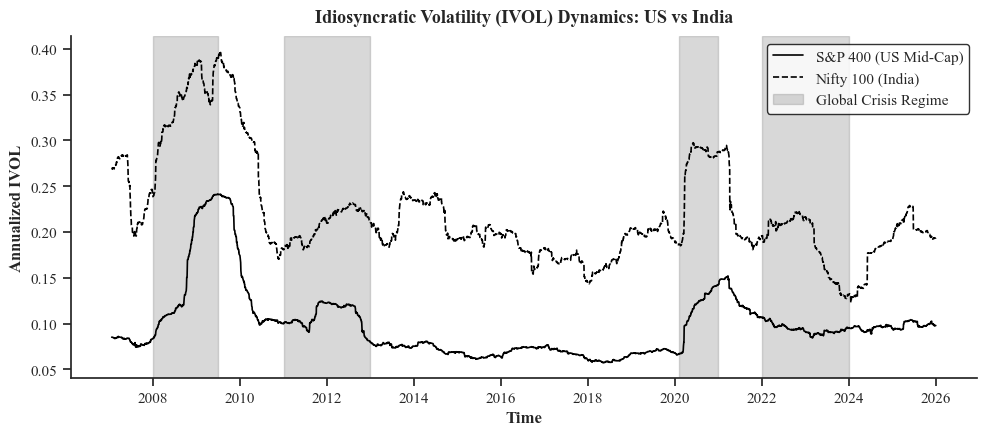

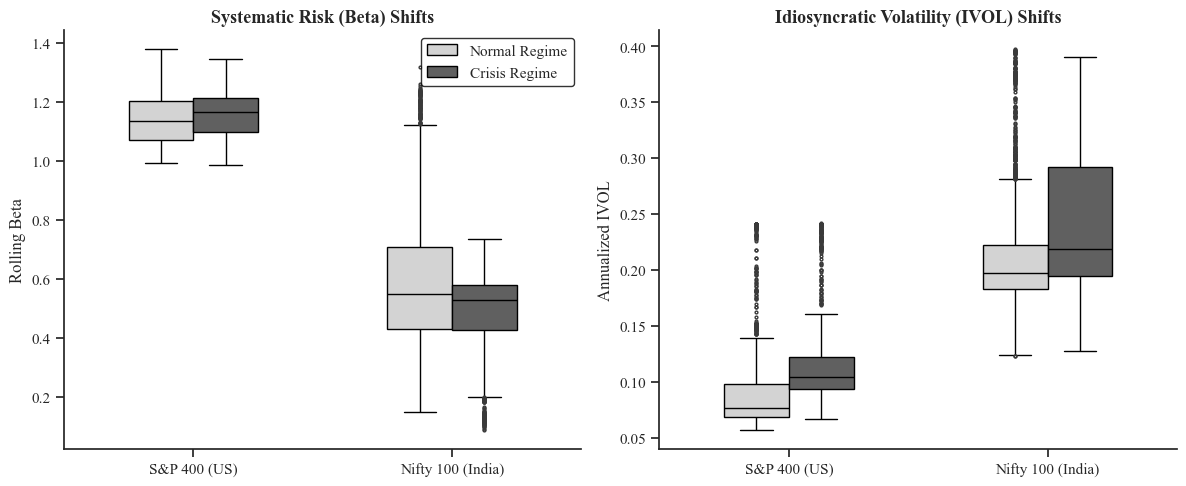

In [224]:
# =============================================================================
# VISUAL ANALYSIS: SYSTEMATIC RISK & IDIOSYNCRATIC VOLATILITY DYNAMICS
# (Versione Accademica B&W / Grayscale)
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd

# =============================================================================
# IMPOSTAZIONI GLOBALI PER PAPER ACCADEMICO
# =============================================================================
# Stile pulito senza griglie colorate
sns.set_style("ticks")

# Configurazione Font: Times New Roman
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

# =============================================================================
# GRAFICO 1: Evoluzione temporale dell'IVOL con Regimi di Crisi evidenziati
# =============================================================================
# Dimensioni tipiche per una figura "double-column" in un paper
fig1, ax1 = plt.subplots(figsize=(10, 4.5))

# Plottiamo le serie temporali usando stili di linea diversi (solida vs tratteggiata) per il B&W
ax1.plot(comp_df.index, comp_df['IVOL_S&P400'], 
         label='S&P 400 (US Mid-Cap)', color='black', linestyle='-', linewidth=1.2)
ax1.plot(comp_df.index, comp_df['IVOL_Nifty100'], 
         label='Nifty 100 (India)', color='black', linestyle='--', linewidth=1.2)

# Ombreggiamo i periodi di crisi (Grigio chiaro)
for start, end in CRISES:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='gray', alpha=0.3, 
                label='Global Crisis Regime' if start == CRISES[0][0] else "")

# Titoli e label (nei paper spesso il titolo principale si omette a favore della caption, 
# ma lo manteniamo sobrio come richiesto)
ax1.set_title("Idiosyncratic Volatility (IVOL) Dynamics: US vs India", fontweight='bold', pad=10)
ax1.set_ylabel("Annualized IVOL", fontweight='bold')
ax1.set_xlabel("Time", fontweight='bold')

# Legenda sobria senza ombre
ax1.legend(loc='upper right', frameon=True, edgecolor='black')
ax1.xaxis.set_major_locator(mdates.YearLocator(2))

# Despine opzionale per pulire il grafico, mantenendo gli assi
sns.despine(ax=ax1, top=True, right=True)

plt.tight_layout()
# Salva il grafico in alta risoluzione (decommenta per usare)
# plt.savefig('fig1_ivol_dynamics.pdf', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# GRAFICO 2: Shift Strutturale di Beta e IVOL (Regime Normale vs Regime di Crisi)
# =============================================================================
# Prepariamo i dati formattandoli per Seaborn (Melt)
plot_df = comp_df.copy()
plot_df['Regime'] = plot_df['Is_Crisis'].map({0: 'Normal Regime', 1: 'Crisis Regime'})

# Ristrutturiamo per il plot del Beta
melted_beta = plot_df.melt(id_vars=['Regime'], value_vars=['beta_S&P400', 'beta_Nifty100'], 
                           var_name='Market', value_name='Systematic Risk (Beta)')
melted_beta['Market'] = melted_beta['Market'].replace({'beta_S&P400': 'S&P 400 (US)', 'beta_Nifty100': 'Nifty 100 (India)'})

# Ristrutturiamo per il plot dell'IVOL
melted_ivol = plot_df.melt(id_vars=['Regime'], value_vars=['IVOL_S&P400', 'IVOL_Nifty100'], 
                           var_name='Market', value_name='Idiosyncratic Volatility (IVOL)')
melted_ivol['Market'] = melted_ivol['Market'].replace({'IVOL_S&P400': 'S&P 400 (US)', 'IVOL_Nifty100': 'Nifty 100 (India)'})

# Creiamo la figura con 2 subplots affiancati
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 5))

# Palette in scala di grigi: Grigio chiaro per normale, Grigio scuro per crisi
palette_bw = {'Normal Regime': '#D3D3D3', 'Crisis Regime': '#606060'}

# Subplot A: Beta
sns.boxplot(data=melted_beta, x='Market', y='Systematic Risk (Beta)', hue='Regime', 
            palette=palette_bw, ax=ax2, width=0.5, fliersize=2, 
            boxprops={'edgecolor':'black'}, medianprops={'color':'black'}, 
            whiskerprops={'color':'black'}, capprops={'color':'black'})

ax2.set_title("Systematic Risk (Beta) Shifts", fontweight='bold')
ax2.set_xlabel("")
ax2.set_ylabel("Rolling Beta")
ax2.legend(frameon=True, edgecolor='black', title="")

# Subplot B: IVOL
sns.boxplot(data=melted_ivol, x='Market', y='Idiosyncratic Volatility (IVOL)', hue='Regime', 
            palette=palette_bw, ax=ax3, width=0.5, fliersize=2,
            boxprops={'edgecolor':'black'}, medianprops={'color':'black'}, 
            whiskerprops={'color':'black'}, capprops={'color':'black'})

ax3.set_title("Idiosyncratic Volatility (IVOL) Shifts", fontweight='bold')
ax3.set_xlabel("")
ax3.set_ylabel("Annualized IVOL")
# Rimuoviamo la seconda legenda per evitare ridondanze visive
ax3.get_legend().remove()

# Pulizia dei bordi
sns.despine(ax=ax2, top=True, right=True)
sns.despine(ax=ax3, top=True, right=True)

plt.tight_layout()
# Salva il grafico in alta risoluzione (decommenta per usare)
# plt.savefig('fig2_structural_shifts.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [215]:
# =============================================================================
# BLOCK 14: EXTREME EVENTS (OUTLIER) ANALYSIS
# =============================================================================
print("\n" + "="*80)
print("ANALYSIS OF EXTREME MARKET EVENTS (FAT TAILS / OUTLIERS)")
print("="*80)

def analyze_extreme_events(df, column_name, market_name):
    """
    Calcola gli outlier superiori (shock estremi) usando il metodo IQR (Interquartile Range),
    lo stesso algoritmo utilizzato matematicamente dai Boxplot.
    """
    series = df[column_name].dropna()
    
    # 1. Calcolo dei limiti del Boxplot
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR  # Questo è il "baffo" superiore del boxplot
    
    # 2. Isolamento dei puntini neri (valori che superano il limite)
    outliers = series[series > upper_bound]
    
    # 3. Calcolo Statistiche
    total_obs = len(series)
    num_outliers = len(outliers)
    perc_outliers = (num_outliers / total_obs) * 100
    
    print(f"\n--- {market_name} ---")
    print(f"  > Soglia statistica di 'normalità' (Upper Whisker): {upper_bound:.4f}")
    print(f"  > Giorni di shock estremo (Outliers): {num_outliers} su {total_obs} ({perc_outliers:.2f}%)")
    
    # 4. Estrazione delle date peggiori
    if not outliers.empty:
        print(f"  > Top 5 date con i picchi più alti (peggiori giornate di panico):")
        top_5 = outliers.sort_values(ascending=False).head(5)
        for date, val in top_5.items():
            # Controlla se questa data cade in un periodo di crisi ufficiale
            is_crisis_day = df.loc[date, 'Is_Crisis'] == 1
            regime_label = "[CRISIS REGIME]" if is_crisis_day else "[NORMAL REGIME]"
            print(f"      * {date.strftime('%Y-%m-%d')} | Valore: {val:.4f} {regime_label}")

# Eseguiamo l'analisi per la Volatilità Idiosincratica (IVOL)
print("\n>>> IDIOSYNCRATIC VOLATILITY (IVOL) SHOCKS")
analyze_extreme_events(comp_df, 'IVOL_S&P400', "S&P 400 (US Mid-Cap)")
analyze_extreme_events(comp_df, 'IVOL_Nifty100', "Nifty 100 (India)")

# Eseguiamo l'analisi per il Rischio Sistematico (Beta)
print("\n>>> SYSTEMATIC RISK (BETA) SHOCKS")
analyze_extreme_events(comp_df, 'beta_S&P400', "S&P 400 (US Mid-Cap)")
analyze_extreme_events(comp_df, 'beta_Nifty100', "Nifty 100 (India)")


ANALYSIS OF EXTREME MARKET EVENTS (FAT TAILS / OUTLIERS)

>>> IDIOSYNCRATIC VOLATILITY (IVOL) SHOCKS

--- S&P 400 (US Mid-Cap) ---
  > Soglia statistica di 'normalità' (Upper Whisker): 0.1599
  > Giorni di shock estremo (Outliers): 290 su 4541 (6.39%)
  > Top 5 date con i picchi più alti (peggiori giornate di panico):
      * 2009-06-26 | Valore: 0.2414 [CRISIS REGIME]
      * 2009-06-25 | Valore: 0.2414 [CRISIS REGIME]
      * 2009-06-29 | Valore: 0.2414 [CRISIS REGIME]
      * 2009-06-30 | Valore: 0.2411 [CRISIS REGIME]
      * 2009-07-14 | Valore: 0.2411 [NORMAL REGIME]

--- Nifty 100 (India) ---
  > Soglia statistica di 'normalità' (Upper Whisker): 0.3047
  > Giorni di shock estremo (Outliers): 474 su 4541 (10.44%)
  > Top 5 date con i picchi più alti (peggiori giornate di panico):
      * 2009-07-15 | Valore: 0.3970 [NORMAL REGIME]
      * 2009-07-14 | Valore: 0.3968 [NORMAL REGIME]
      * 2009-07-16 | Valore: 0.3963 [NORMAL REGIME]
      * 2009-07-22 | Valore: 0.3958 [NORMAL RE

In [216]:
'''
### 💡 Discussion of Extreme Market Events (Outlier Analysis) IT'S NOT CODE JUST A COMMENT

The outlier analysis, mathematically derived using the Interquartile Range (IQR) bounds, provides critical quantitative insights into our Research Question. Three major findings emerge regarding the shifting dynamics of systematic and idiosyncratic risks:

**1. Quantification of "Fat Tails" and Market Asymmetry**
The data reveals pronounced *fat tails* in the idiosyncratic volatility (IVOL) distribution for both indices. However, the Nifty 100 exhibits a significantly higher frequency of extreme events (**10.44%**) compared to the S&P 400 (**6.39%**). This structural asymmetry confirms that emerging market equities are inherently exposed to much more frequent and violent idiosyncratic shocks compared to developed mid-cap markets.

**2. The "Lag" Effect and Spillover of the 2008 Crisis**
The historical timeline of the Top 5 IVOL peaks reveals an interesting delayed spillover effect. The US market (S&P 400) reaches its absolute idiosyncratic volatility peak at the end of June 2009, squarely within the defined Global Financial Crisis regime. In contrast, the Indian market (Nifty 100) records its absolute worst shocks—with IVOL nearing 0.40—in mid-July 2009. This timeline suggests that the aftershocks of a global systemic crisis take longer to be fully priced in and absorbed by emerging markets, prolonging the panic state even as developed markets begin to stabilize.

**3. Divergent Stability in Systematic Risk (Beta)**
Systematic risk behaves in stark contrast to idiosyncratic risk. The S&P 400 displays impressive structural stability, recording exactly **0.00%** Beta outliers. It maintains a highly predictable and unbroken sensitivity to the global market across two decades. Conversely, the Nifty 100 experiences Beta shocks (**2.55%**), primarily concentrated in the pre-crisis period of mid-2007. This implies that in emerging markets, even the fundamental correlation with the global benchmark can suffer sudden structural breaks, likely driven by periods of local market overheating.

**Conclusion:** During global crises, US Mid-Cap markets experience idiosyncratic volatility shocks but remain firmly anchored to global market dynamics (stable Beta). Emerging markets like India, on the other hand, suffer from more frequent IVOL shocks, reach higher absolute levels of panic with a delayed recovery, and exhibit occasional structural breaks in their systematic risk profile.'''

'\n### 💡 Discussion of Extreme Market Events (Outlier Analysis) IT\'S NOT CODE JUST A COMMENT\n\nThe outlier analysis, mathematically derived using the Interquartile Range (IQR) bounds, provides critical quantitative insights into our Research Question. Three major findings emerge regarding the shifting dynamics of systematic and idiosyncratic risks:\n\n**1. Quantification of "Fat Tails" and Market Asymmetry**\nThe data reveals pronounced *fat tails* in the idiosyncratic volatility (IVOL) distribution for both indices. However, the Nifty 100 exhibits a significantly higher frequency of extreme events (**10.44%**) compared to the S&P 400 (**6.39%**). This structural asymmetry confirms that emerging market equities are inherently exposed to much more frequent and violent idiosyncratic shocks compared to developed mid-cap markets.\n\n**2. The "Lag" Effect and Spillover of the 2008 Crisis**\nThe historical timeline of the Top 5 IVOL peaks reveals an interesting delayed spillover effect. Th

In [220]:
# =============================================================================
# CORRELATION TABLES DIAGNOSTIC (NORMAL vs CRISIS) - COPY/PASTE BLOCK
# =============================================================================

import numpy as np
import pandas as pd

print("\n" + "="*80)
print("CORRELATION DIAGNOSTIC: VERIFY NORMAL vs CRISIS MATRICES (FROM comp_df)")
print("="*80)

# --- 0) Basic checks ---
if "comp_df" not in globals():
    raise NameError("comp_df not found. Make sure you created comp_df before running this block.")

print(f"comp_df shape: {comp_df.shape}")
print(f"comp_df columns: {len(comp_df.columns)}")

# --- 1) Auto-detect CRISIS column ---
crisis_candidates = [c for c in comp_df.columns if "crisis" in str(c).lower()]
print("\nCrisis-like columns found:", crisis_candidates)

if len(crisis_candidates) == 0:
    raise ValueError(
        "No crisis column detected in comp_df.\n"
        "Fix: ensure the crisis dummy is created and merged into comp_df.\n"
        "Hint: look for columns like 'Crisis', 'crisis_dummy', 'CrisisFlag', etc."
    )

def _choose_crisis_col(cands):
    # Prefer a column that suggests US/SP/market tagging; else take first
    priority = []
    for c in cands:
        cl = str(c).lower()
        score = 0
        if "us" in cl or "sp" in cl or "s&p" in cl or "sp400" in cl: score += 3
        if "dummy" in cl or "flag" in cl: score += 1
        priority.append((score, c))
    priority.sort(reverse=True, key=lambda x: x[0])
    return priority[0][1]

crisis_col = _choose_crisis_col(crisis_candidates)
print("Selected crisis column:", crisis_col)

# Ensure crisis is binary-ish
unique_crisis_vals = pd.Series(comp_df[crisis_col].dropna().unique()).sort_values().tolist()
print("Crisis unique values (non-NaN):", unique_crisis_vals[:20], ("..." if len(unique_crisis_vals) > 20 else ""))

# --- 2) Auto-detect BETA and IVOL columns ---
beta_candidates = [c for c in comp_df.columns if "beta" in str(c).lower()]
ivol_candidates = [c for c in comp_df.columns if "ivol" in str(c).lower()]

print("\nBeta columns found:", beta_candidates)
print("IVOL columns found:", ivol_candidates)

if len(beta_candidates) < 2 or len(ivol_candidates) < 2:
    raise ValueError(
        "Need at least 2 beta columns and 2 ivol columns in comp_df to build a 4-variable correlation matrix.\n"
        f"Found beta={len(beta_candidates)}, ivol={len(ivol_candidates)}.\n"
        "Fix: check your merge/suffixes. You likely have columns like Beta_US/Beta_India and IVOL_US/IVOL_India\n"
        "or Beta_sp400/Beta_nifty and IVOL_sp400/IVOL_nifty."
    )

def _pair_beta_ivol(beta_cands, ivol_cands):
    """
    Try to infer the two markets and pair (beta, ivol) for each market.
    Strategy:
      - Identify market tags from beta column names.
      - For each beta, find ivol with maximum token overlap.
    """
    def tokens(name):
        name = str(name).lower().replace("&", "and").replace(" ", "_")
        for ch in ["-", ".", "(", ")", "[", "]"]:
            name = name.replace(ch, "_")
        return set([t for t in name.split("_") if t and t not in {"beta", "ivol"}])

    beta_tok = {b: tokens(b) for b in beta_cands}
    ivol_tok = {v: tokens(v) for v in ivol_cands}

    pairs = []
    used_ivol = set()

    for b in beta_cands:
        best = None
        best_score = -1
        for v in ivol_cands:
            if v in used_ivol:
                continue
            score = len(beta_tok[b].intersection(ivol_tok[v]))
            # slight preference if both share "us/india/sp/nifty" etc
            if any(k in beta_tok[b] and k in ivol_tok[v] for k in {"us","india","sp","sp400","nifty","nifty100","s&p"}):
                score += 2
            if score > best_score:
                best_score = score
                best = v
        if best is not None:
            pairs.append((b, best, best_score))
            used_ivol.add(best)

    # Keep top 2 pairs with highest score
    pairs.sort(key=lambda x: x[2], reverse=True)
    return pairs[:2]

pairs = _pair_beta_ivol(beta_candidates, ivol_candidates)

if len(pairs) < 2:
    raise ValueError(
        "Could not confidently pair beta and ivol columns into two markets.\n"
        "Fix: rename your columns to a consistent scheme, e.g.\n"
        "Beta_US, IVOL_US, Beta_India, IVOL_India"
    )

# Extract chosen columns
beta1, ivol1, s1 = pairs[0]
beta2, ivol2, s2 = pairs[1]

chosen_cols = [beta1, ivol1, beta2, ivol2]
print("\nChosen (Beta, IVOL) pairs:")
print(f"  Market A: {beta1}  +  {ivol1}   (match score={s1})")
print(f"  Market B: {beta2}  +  {ivol2}   (match score={s2})")
print("Final columns used for correlation:", chosen_cols)

# --- 3) Build clean analysis dataset ---
df_use = comp_df[[crisis_col] + chosen_cols].copy()

# Force numeric for correlation columns
for c in chosen_cols:
    df_use[c] = pd.to_numeric(df_use[c], errors="coerce")

# Crisis should be int-like (0/1). Coerce gently:
df_use[crisis_col] = pd.to_numeric(df_use[crisis_col], errors="coerce")

before_drop = len(df_use)
df_use = df_use.dropna(subset=[crisis_col] + chosen_cols).reset_index(drop=True)
after_drop = len(df_use)

print("\nData cleaning:")
print(f"  Rows before dropna: {before_drop}")
print(f"  Rows after  dropna: {after_drop}")
print(f"  Dropped rows:       {before_drop - after_drop}")

# Validate crisis values
cr_vals = sorted(df_use[crisis_col].unique().tolist())
print("Crisis values after cleaning:", cr_vals)

# If crisis isn't strictly 0/1, try binarizing (common case: True/False)
if set(cr_vals).issubset({0, 1}) is False:
    # If values are {False, True} already numeric -> should be {0,1}; else if {0,1,2} etc -> binarize >0
    print("WARNING: Crisis column is not strictly {0,1}. Applying binarization: crisis = (value > 0).")
    df_use[crisis_col] = (df_use[crisis_col] > 0).astype(int)

# --- 4) Split normal vs crisis ---
normal_df = df_use[df_use[crisis_col] == 0]
crisis_df = df_use[df_use[crisis_col] == 1]

print("\nSample sizes:")
print(f"  Total (clean): {len(df_use)}")
print(f"  Normal:        {len(normal_df)}")
print(f"  Crisis:        {len(crisis_df)}")

if len(normal_df) < 30 or len(crisis_df) < 30:
    print("WARNING: One regime has <30 observations. Correlations may be unstable (check crisis definition/window).")

# --- 5) Correlation matrices ---
corr_normal = normal_df[chosen_cols].corr()
corr_crisis = crisis_df[chosen_cols].corr()

print("\n" + "-"*80)
print("CORRELATION MATRIX - NORMAL REGIME (Crisis=0)")
print("-"*80)
print(corr_normal.round(4))

print("\n" + "-"*80)
print("CORRELATION MATRIX - CRISIS REGIME (Crisis=1)")
print("-"*80)
print(corr_crisis.round(4))

# --- 6) Optional: Quick sanity check on sign flips for Beta-IVOL within each market ---
def _safe_corr(df, x, y):
    if len(df) < 3:
        return np.nan
    return df[[x, y]].corr().iloc[0, 1]

print("\n" + "-"*80)
print("SANITY: Beta-IVOL correlations by market")
print("-"*80)
print(f"Normal  corr({beta1},{ivol1}) = {_safe_corr(normal_df, beta1, ivol1):.4f}")
print(f"Crisis  corr({beta1},{ivol1}) = {_safe_corr(crisis_df, beta1, ivol1):.4f}")
print(f"Normal  corr({beta2},{ivol2}) = {_safe_corr(normal_df, beta2, ivol2):.4f}")
print(f"Crisis  corr({beta2},{ivol2}) = {_safe_corr(crisis_df, beta2, ivol2):.4f}")

# --- 7) Save outputs (optional) ---
# corr_normal.to_csv("corr_normal_final.csv")
# corr_crisis.to_csv("corr_crisis_final.csv")

print("\nDone. If these matrices differ from the paper/PPT tables, the paper/PPT tables were generated from a different dataset or stage of the pipeline.")



CORRELATION DIAGNOSTIC: VERIFY NORMAL vs CRISIS MATRICES (FROM comp_df)
comp_df shape: (4541, 5)
comp_df columns: 5

Crisis-like columns found: ['Is_Crisis']
Selected crisis column: Is_Crisis
Crisis unique values (non-NaN): [0, 1] 

Beta columns found: ['beta_S&P400', 'beta_Nifty100']
IVOL columns found: ['IVOL_S&P400', 'IVOL_Nifty100']

Chosen (Beta, IVOL) pairs:
  Market A: beta_Nifty100  +  IVOL_Nifty100   (match score=3)
  Market B: beta_S&P400  +  IVOL_S&P400   (match score=1)
Final columns used for correlation: ['beta_Nifty100', 'IVOL_Nifty100', 'beta_S&P400', 'IVOL_S&P400']

Data cleaning:
  Rows before dropna: 4541
  Rows after  dropna: 4541
  Dropped rows:       0
Crisis values after cleaning: [0, 1]

Sample sizes:
  Total (clean): 4541
  Normal:        3007
  Crisis:        1534

--------------------------------------------------------------------------------
CORRELATION MATRIX - NORMAL REGIME (Crisis=0)
-----------------------------------------------------------------------